# Exploit the information to support decision making (README)

**In this section we aim at illustrating the value added of gridded data time-series of solar irradiation vs single point time-series of solar irradiation.**
#### Comparison with NUTS-3-region-wise average and geometrical AOI (Areal Of Interest)
* Demonstrate with this example the lack of representativeness of point-wise solar resource assessment for an extended region such as the NUT 3 region and for geometrical AOI.

**Gridded solar ressource assessment is required to provide representative spatially aggregated profiles !!!**

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, COLORS

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon


import h5py


# Upload and prepare data

We assume that the data have already been downloaded using the WPS service. For details on that part, see [URL].
In our case we loading data over France. 

To cross our data with existing maps and borders, we use the python libraries geopandas and shapely. 

In [153]:
# First, transform hdf5 in geodata

with h5py.File('NextGEOSS_CAMS_output.nc', 'r') as hf:

    # We need the lat/lon of each pixel
    # The lat lon are stored as array in the hfd file, they must thus be transformed into 2D matrices:
    my_lat = hf['lat'][:]
    my_lon = hf['lon'][:]
    
    width = len(my_lon)
    height = len(my_lat)
    count = len(hf['time'])

    my_lat = np.transpose(np.stack([my_lat]*width))
    my_lon = np.stack([my_lon]*height)

    # We build a geodataframe containing location information for each pixel on the image:
    my_gpd = gpd.GeoDataFrame()
    my_gpd['Coordinates'] = list(zip(my_lon.flatten(), my_lat.flatten()))
    my_gpd['geometry'] = my_gpd['Coordinates'].apply(Point)
    my_gpd.crs = {'init' :'epsg:4326'}
    my_gpd.head()

    # A (regular, pandas) DataFrame is then build. 
    # Each column corresponds to one of the pixel referenced in the GeoDataFrame defined previously.
    # The column name correponds to the pixel's coordinates.
    my_tsdf = pd.DataFrame(hf['GHI'][:].reshape(count,width*height),index=range(count))
    my_tsdf.columns=my_gpd.Coordinates
    my_tsdf = my_tsdf.fillna(0)


In [154]:
# The following function allows the retrieval of a single time stamp over the whole area
my_geom = my_gpd.geometry
def get_frame_df(t):
    plot_gpd = gpd.GeoDataFrame(my_tsdf.loc[t].transpose())
    plot_gpd.columns = ['GHI']
    plot_gpd = plot_gpd.reset_index()
    plot_gpd['geometry'] = my_geom
    return(plot_gpd)


# Usecase 1: administrative area of interest

In [4]:
# Load France adminstrative border
laFrance = gpd.read_file('GeoData/DEPARTEMENT_METROPOLE.geojson')
laFrance = laFrance.to_crs({'init' :'epsg:4326'})
#laFrance.head()

# Extract the shape of Herault from file:
my_dpt = laFrance[laFrance.NOM_DEPT=='HERAULT']

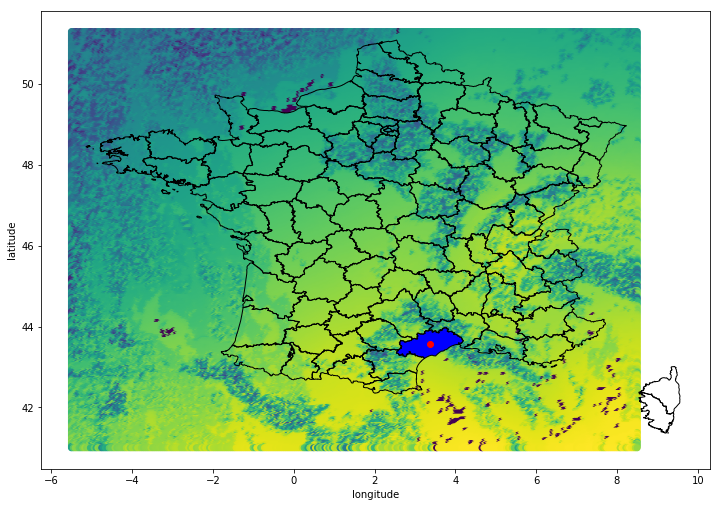

In [5]:

# Plot shape on top of our data:
## We use our data as base for our plot:
frame_to_plot = get_frame_df(45)
base = frame_to_plot.plot( column='GHI',figsize=(12,12))
base.set_xlabel("longitude")
base.set_ylabel("latitude")

## Add French borders to the plot:
laFrance.boundary.plot(ax=base,color='black',lw=1)
#base.set_ylim(lat_min, lat_max)
#base.set_xlim(lon_min, lon_max)



## Plot department and its center
my_dpt.plot(ax=base,color='blue',lw=2)
my_dpt.centroid.plot(ax=base,color='red')


## Extract data and compare resources

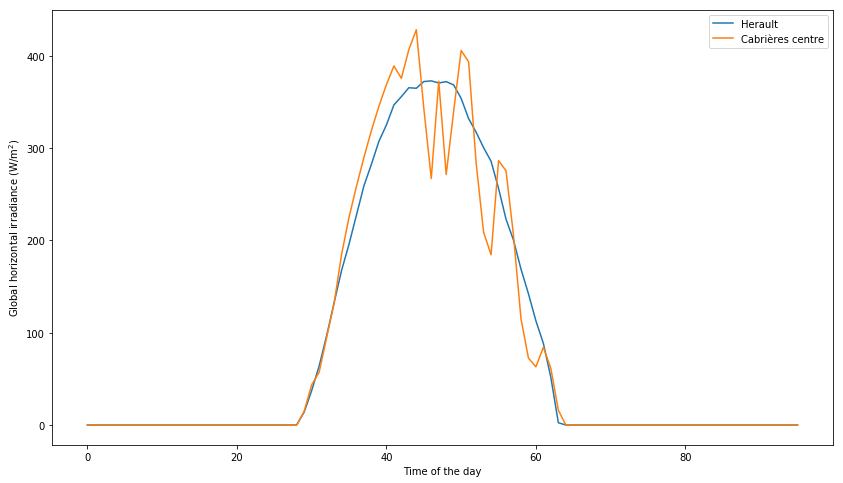

In [14]:
# Resource for Herault:
herault_intersection = my_gpd.within(my_dpt.geometry.iloc[0])
herault_ts = my_tsdf.loc[:,my_gpd[herault_intersection].Coordinates].mean(axis=1)

# Resource for its center:
distance = my_gpd.geometry.apply(lambda x: my_dpt.centroid.distance(x))
nearest_pt = my_gpd.iloc[distance.idxmin()]
center_ts_u1 = my_tsdf[nearest_pt.Coordinates.iloc[0]]



plt.figure(figsize=(14,8))
plt.plot(herault_ts,label='Herault')
plt.plot(center_ts_u1,label='Cabrières centre')
plt.xlabel('Time of the day')
plt.ylabel('Global horizontal irradiance (W/m$^2$)')
plt.legend()

# Usecase 2: select a geometrical area of interest

In [7]:
# Define geometrical AOI:
p1 = Polygon([(3.7,43.4),(4,43.4),(4,43.8),(3.7,43.8)])
myPol = gpd.GeoSeries(p1)
myPol.crs = {'init' :'epsg:4326'}

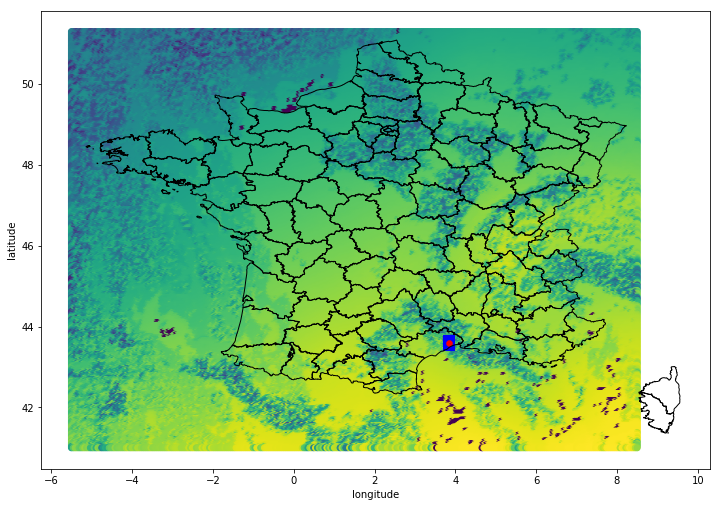

In [8]:
# Plot shape on top of our data:
## We use our data as base for our plot:
frame_to_plot = get_frame_df(45)
base = frame_to_plot.plot( column='GHI',figsize=(12,12))
base.set_xlabel("longitude")
base.set_ylabel("latitude")

## Add French borders to the plot:
laFrance.boundary.plot(ax=base,color='black',lw=1)
# base.set_ylim(lat_min, lat_max)
# base.set_xlim(lon_min, lon_max)

## Plot our polygon and its center
myPol.plot(ax=base,color='blue')
myPol.centroid.plot(ax=base,color='red',lw=.5)


## Extract data and compare resources

In [9]:
# Extract resources for geometrical AOI:
my_intersection = my_gpd.within(myPol.geometry.iloc[0])
zone_ts = my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1)
my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1).iloc[45:55]


# Resource for its center:
distance = my_gpd.geometry.apply(lambda x: myPol.distance(x))
nearest_pt = my_gpd.iloc[distance.idxmin()]
center_ts_u2 = my_tsdf[nearest_pt.Coordinates.iloc[0]]

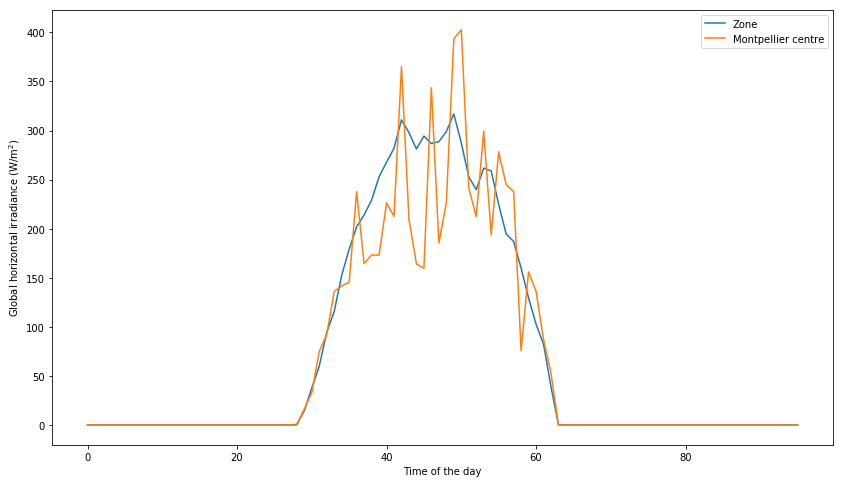

In [10]:

# Compare resources
plt.figure(figsize=(14,8))
plt.plot(zone_ts,label='Zone')
plt.plot(center_ts_u2,label='Montpellier centre')
plt.xlabel('Time of the day')
plt.ylabel('Global horizontal irradiance (W/m$^2$)')
plt.legend()

# Usecase 3: Daily average per department

## Calculate daily average

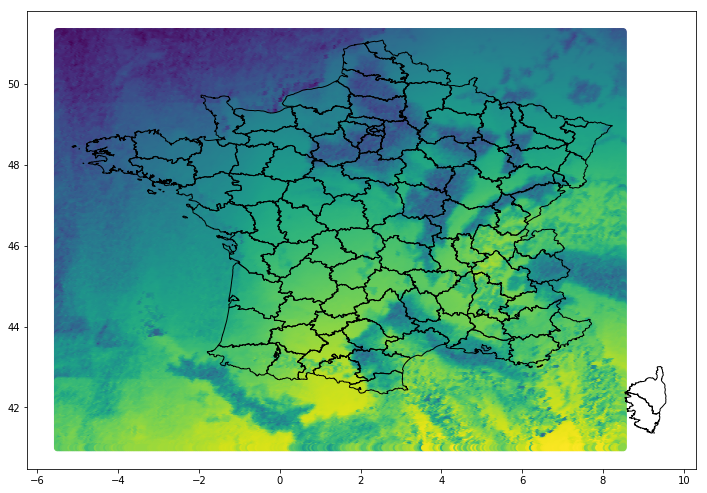

In [167]:
my_geom = my_gpd.geometry
plot_gpd = gpd.GeoDataFrame(my_tsdf.mean(0).transpose())
plot_gpd.columns = ['GHI']
plot_gpd = plot_gpd.reset_index()
plot_gpd['geometry'] = my_geom

base = plot_gpd.plot('GHI',figsize=(12,12))
laFrance.boundary.plot(ax=base,color='black',lw=1)


## Aggregate data per department

In [197]:
laFranceAverage = laFrance.copy()
laFranceAverage['GHI_mean'] = 0
for j,idx in enumerate(laFranceAverage.index):
    dpt_intersec = my_gpd.within(laFranceAverage.loc[idx].geometry)
    dpt_resources = my_tsdf.loc[:,my_gpd[dpt_intersec].Coordinates].mean().mean()
    laFranceAverage.loc[idx,'GHI_mean'] = dpt_resources
    print(j,end=', ')


84.08159, 89.953896, 61.63935, 71.52836, 83.65189, 58.216824, 66.53525, 72.59058, 70.198715, 79.492004, 96.897514, 89.897026, 65.19696, 56.132763, 57.226257, 95.57295, 63.535053, 87.65615, 68.14419, 66.29114, 77.35256, 102.30647, 61.320732, 65.291916, 74.01052, 93.84738, 94.1187, 95.156784, 79.27033, 57.69239, 76.06665, 86.720245, 92.511345, 72.07752, 91.158356, 54.619312, 101.05839, 82.37108, 93.66913, 90.46543, 92.983925, 53.2052, 87.14638, 95.228294, 66.96656, 60.211395, nan, 90.29097, 52.738026, 88.81039, 80.95415, 56.07972, 92.15635, 75.63439, 98.8089, 91.19046, 87.13645, 80.013565, 84.79063, 74.36051, 90.264946, 85.00251, 68.96145, 53.77864, 92.61962, 76.277626, 96.74709, 72.09987, 76.371925, 101.99234, 88.29129, 74.78683, 98.68722, 103.08315, 84.856415, 85.51769, 58.867584, 76.132286, nan, 92.60293, 64.92889, 54.730015, 81.30476, 85.77043, 94.11208, 81.13009, 94.66565, 69.37328, 51.695477, 59.756065, 63.388126, 77.8697, 71.694214, 73.73091, 71.558784, 82.19691, 

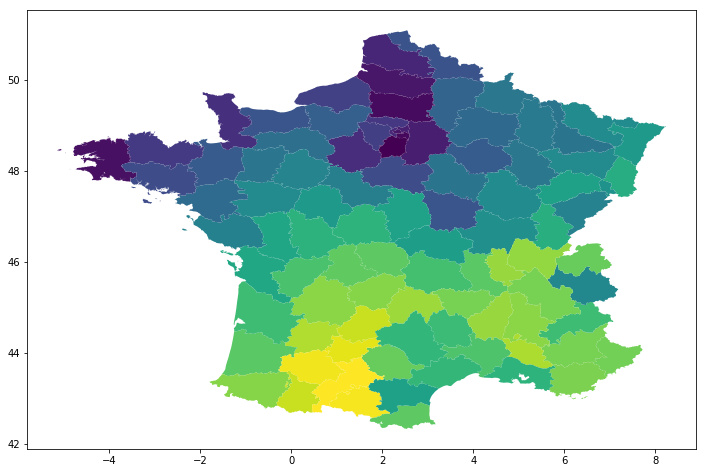

In [201]:
laFranceAverage.dropna().plot('GHI_mean',figsize=(12,12))